# Sequential Gaussian simulation

We saw in the kriging example that kriging does not reproduce the variogram statistics of the data, making it an unrealistically smooth representation of geologically phenomena. To reproduce the variogram statistics, we perform sequential Gaussian simulation, a common method for stochastic simulation.

In [13]:
import sys
sys.path.append("../../")

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer 
import gstatsim as gs
import skgstat as skg
from skgstat import models
import parallel
import random

## Load and plot data

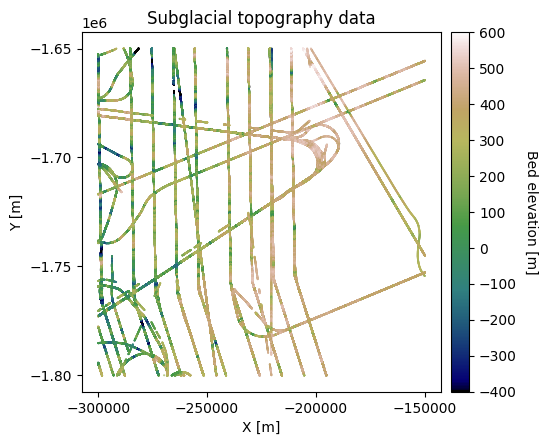

In [15]:
df_bed = pd.read_csv('../data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-400, vmax=600, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

## Grid and transform data, compute variogram parameters

In [16]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 500
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'

## Initialize grid

Make list of grid cells that need to be simulated.

In [17]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Sequential Gaussian simulation

Sequential Gaussian simulation (SGS) uses kriging to sequentially estimate the kriging mean and variance at each grid cell. This mean and variance define a Gaussian probability distribution from which a random value sampled in order to simulate a grid cell.

:::{figure-md} markdown-fig
<img src="./Images/SGS_cartoon-01.jpg" class="bg-primary mb-1" width="700px">

Sequential Gaussian simulation
:::

We have two versions of sequential Gaussian simulation, skrige_sgs and okrige_sgs, which use simple and ordinary kriging, respectively. In this example we use okrige_sgs.

In [18]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
vtype = 'Exponential'

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, vtype]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 50000    # 50 km search radius

sim_par = parallel.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad, 10) 

In [ ]:
rows

In [19]:
# reverse normal score transformation
sim1_par = sim_par.reshape(-1,1)
sim_trans_par = nst_trans.inverse_transform(sim1_par)

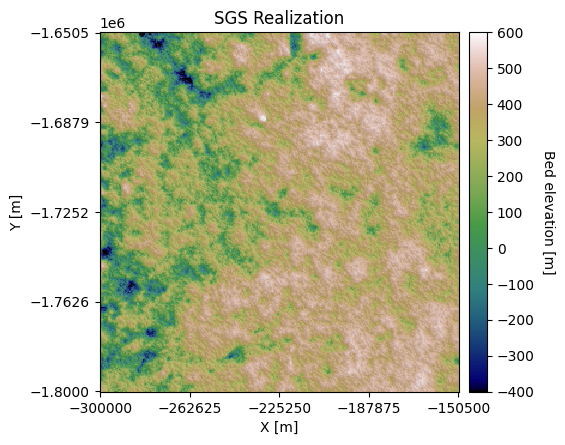

In [20]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
mat = sim_trans_par.reshape((rows, cols))
xmin = Pred_grid_xy[:,0].min(); xmax = Pred_grid_xy[:,0].max()
ymin = Pred_grid_xy[:,1].min(); ymax = Pred_grid_xy[:,1].max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS Realization')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

In [21]:
sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 

 43%|████▎     | 38379/90000 [03:59<06:52, 125.22it/s]

KeyboardInterrupt: 

 43%|████▎     | 38379/90000 [04:14<06:52, 125.22it/s]

In [ ]:
# reverse normal score transformation
sim1 = sim.reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim1)

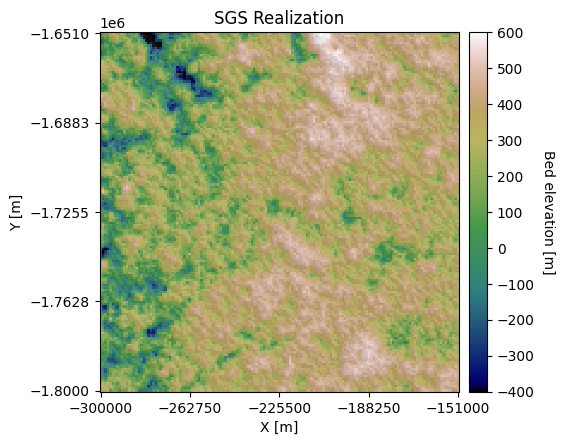

In [ ]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
mat = sim_trans.reshape((rows, cols))
xmin = Pred_grid_xy[:,0].min(); xmax = Pred_grid_xy[:,0].max()
ymin = Pred_grid_xy[:,1].min(); ymax = Pred_grid_xy[:,1].max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS Realization')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

SGS can be used to simulate multiple realizations for quantifying uncertainty. Let's generate a couple more realizations.

In [ ]:
# simulate multiple random realizations

# simulation 2
sim2 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
sim2 = sim2.reshape(-1,1)
sim2_trans = nst_trans.inverse_transform(sim2)

# simulation 3
sim3 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
sim3 = sim3.reshape(-1,1)
sim3_trans = nst_trans.inverse_transform(sim3)

 68%|██████▊   | 15227/22500 [01:12<00:42, 170.44it/s]

KeyboardInterrupt: 

 68%|██████▊   | 15227/22500 [01:27<00:42, 170.44it/s]

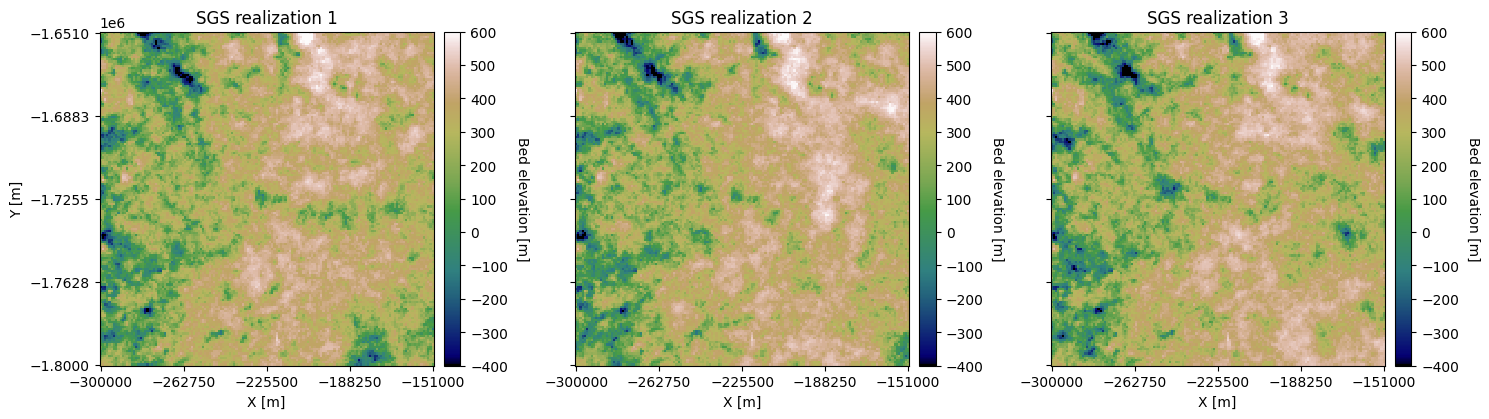

In [ ]:
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))

plots = [sim_trans, sim2_trans, sim3_trans]

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for i, (ax, plot) in enumerate(zip(axs, plots)):
    sgs_mat = plot.reshape((rows, cols))
    im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=-400, vmax=600, cmap='gist_earth')
    ax.set_title(f'SGS realization {i+1}')
    ax.set_xlabel('X [m]')
    if i == 0:
        ax.set_ylabel('Y [m]')
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
    cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
    ax.axis('scaled')
    
plt.tight_layout()
plt.show()

You can see that they all look a bit different from each other.

## SGS Roughness

The topography generated using SGS is much rougher than the kriging examples. Let's check the variograms to see if the roughness statistics of the data are reproduced.

In [ ]:
# compute SGS variogram

# downsample random indices to speed this up
rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),5000)

# get coordinates and normalized simulation from random indices
coords_s = Pred_grid_xy[rand_indices]
values_s = sim[rand_indices]

VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

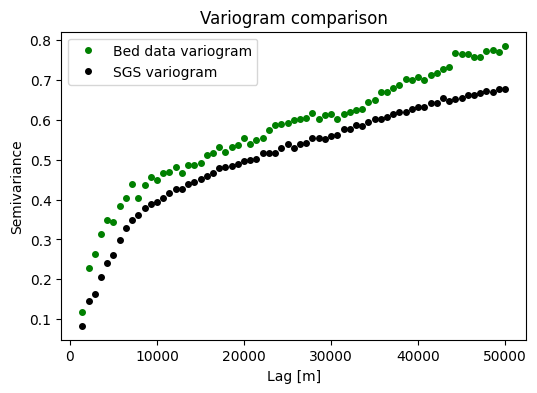

In [ ]:
# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

plt.figure(figsize=(6,4))
plt.plot(xe,ye,'og', markersize=4, label = 'Bed data variogram')
plt.plot(xs,ys,'ok', markersize=4, label = 'SGS variogram')
plt.title('Variogram comparison')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='upper left')
plt.show()

We can see that the variograms are very similar. This means that SGS is reproducing the spatial statistics of observations.

Download the tutorial {Download}`here<./4_Sequential_Gaussian_Simulation.ipynb>`.